In [2]:
import torch
import torchvision
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.optim import lr_scheduler
import datetime
import numpy as np
import argparse
from torchsummary import summary

/home/sinan/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [106]:
num_epochs = 25
batch_size = 2048
learning_rate = 1e-3

train_transform = transforms.Compose([transforms.ToTensor()])
train_set = MNIST('./data/mnist', train=True, download=True, transform=train_transform)
test_set = MNIST(root='./data/mnist',  train=False, download=True, transform=train_transform)
dataloader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
dataloaderTest = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=True)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# idx = int(input("Pick a number: "))

# plt.imshow(train_set.data[idx], cmap='gray')
# plt.show()

In [73]:
class autoencoderMLP4(nn.Module):
    def __init__(self, N_input=784, N_bottleneck=16, N_output=784):
        super(autoencoderMLP4, self).__init__()
        N2 = 392
        self.fc1 = nn.Linear(N_input, N2)
        self.fc2 = nn.Linear(N2, N_bottleneck)
        self.fc3 = nn.Linear(N_bottleneck, N2)
        self.fc4 = nn.Linear(N2, N_output)
        self.type = "MLP4"
        self.input_shape = (1, 28*28)
        
    def forward(self, X):
        X = self.fc1(X)
        X = F.relu(X)
        X = self.fc2(X)

        X = self.fc3(X)
        X = F.relu(X)
        X = self.fc4(X)
        X = torch.sigmoid(X)

        return X
    
    def encode(self, X):
        X = self.fc1(X)
        X = F.relu(X)
        X = self.fc2(X)

        return X

    def decode(self, X):
        X = self.fc3(X)
        X = F.relu(X)
        X = self.fc4(X)
        X = torch.sigmoid(X)

        return X

In [113]:
def train(n_epochs, optimizer, model, loss_fn, train_loader, scheduler, device):
    model.train().to(device)
    losses_train = []
    # Model outputs pixely images not grey scale
    # must use binary cross entropy loss 
    for epoch in range(1, n_epochs+1):
        print('epoch ', epoch)
        loss_train = 0.0
        for imgs in train_loader:
            img, _ = imgs
            img = img.view(img.size(0), -1)
            img = Variable(img).to(device)
            outputs = model(img).to(device)
            loss = loss_fn(outputs, img)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_train += loss.item()

        #scheduler.step(loss_train)

        losses_train += [loss_train/len(train_loader)]

        print('{} Epoch {}, Training loss {}'.format(datetime.datetime.now(), epoch, loss_train/len(train_loader)))
    plt.style.use('fivethirtyeight')
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.plot(losses_train[-100:])
    plt.show()

epoch  1
2023-09-19 19:27:20.381634 Epoch 1, Training loss 0.10707190285126368
epoch  2
2023-09-19 19:27:26.777435 Epoch 2, Training loss 0.06412216735382875
epoch  3
2023-09-19 19:27:33.036984 Epoch 3, Training loss 0.052893103038271265
epoch  4
2023-09-19 19:27:39.379293 Epoch 4, Training loss 0.044843534504373866
epoch  5
2023-09-19 19:27:45.620096 Epoch 5, Training loss 0.03857719252506892
epoch  6
2023-09-19 19:27:51.959104 Epoch 6, Training loss 0.033848808022836845
epoch  7
2023-09-19 19:27:58.248721 Epoch 7, Training loss 0.029729852887491384
epoch  8
2023-09-19 19:28:04.648993 Epoch 8, Training loss 0.0264491048331062
epoch  9
2023-09-19 19:28:10.814182 Epoch 9, Training loss 0.023619219660758972
epoch  10
2023-09-19 19:28:17.407874 Epoch 10, Training loss 0.0217433862388134
epoch  11
2023-09-19 19:28:23.856556 Epoch 11, Training loss 0.020306265354156493
epoch  12
2023-09-19 19:28:30.232070 Epoch 12, Training loss 0.0191864758109053
epoch  13
2023-09-19 19:28:36.613852 Epoch 

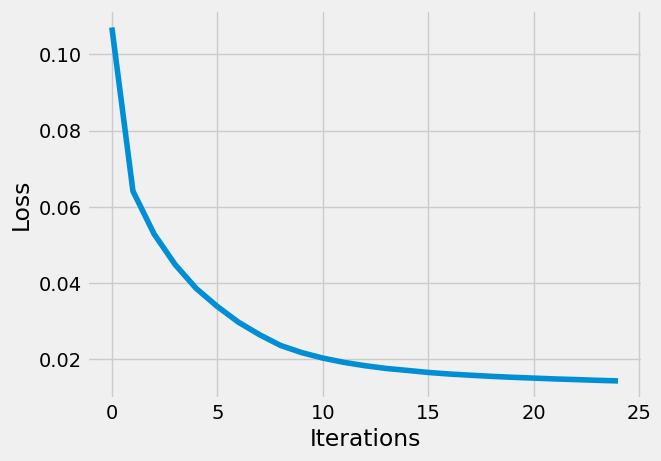

In [75]:
model = autoencoderMLP4().to(device)
loss_f = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
scheduler = lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)
train(num_epochs, optimizer, model, loss_f, dataloader, scheduler, device)

In [ ]:
summary(model, (1, 28*28))

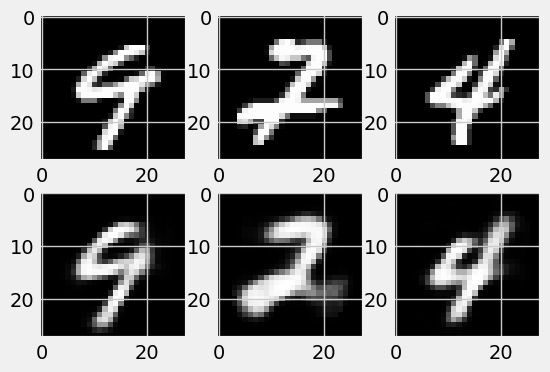

In [180]:
model.eval()

for imgs in dataloaderTest:
    img, _ = imgs
    img = img.view(img.size(0), -1)
    img = Variable(img).to(device)
    # why is model adding noise?
    with torch.no_grad():
        outputs = model(img).to(device)

# plot original images and output
plt.figure(figsize=(20, 4))
for idx in np.arange(3):
    plt.subplot(2, 10, idx+1)
    plt.imshow(img[idx].cpu().numpy().reshape(28, 28), cmap='gray')
    plt.subplot(2, 10, idx+11)
    plt.imshow(outputs[idx].cpu().detach().numpy().reshape(28, 28), cmap='gray')
plt.show()




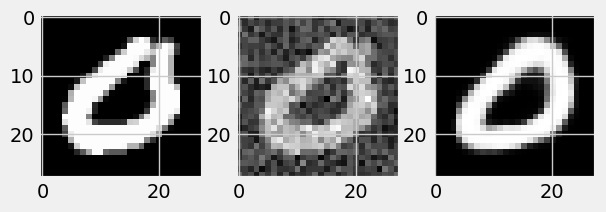

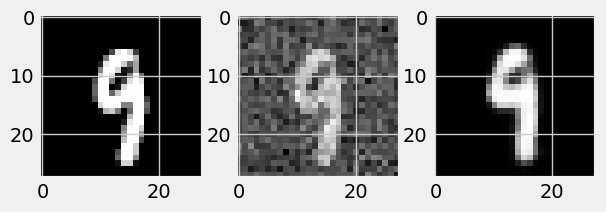

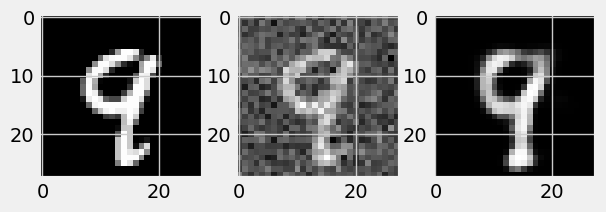

In [182]:
normal_images = []
images_with_noise = []

for i in range(3):
    training_image_idx = np.random.randint(0, len(dataloaderTest.dataset))   # get a random number from 0 to the length of the training set
    current_image = dataloaderTest.dataset[training_image_idx][0]
    normal_images.append(current_image)    # append the normal image to this list
    noise = torch.randn(current_image.size()) * 0.2
    images_with_noise.append(current_image + noise)    # append the noisy image to this list
    
images_with_noise = torch.stack(images_with_noise)
images_with_noise = images_with_noise.view(images_with_noise.size(0), -1)
images_with_noise = images_with_noise.type(torch.float32)
images_with_noise = Variable(images_with_noise).to(device)
with torch.no_grad():
    output = model(images_with_noise).to(device)

output = output.cpu()
images_with_noise = images_with_noise.cpu()
output = output.reshape(-1, 28, 28)
images_with_noise = images_with_noise.reshape(-1, 28, 28)

# the noisy image should be at the same index in it's list as its corresponding noiseless image
for i, current_image in enumerate(images_with_noise):
    f = plt.figure()
    f.add_subplot(1,3,1)
    plt.imshow(normal_images[i].reshape(28, 28), cmap='gray')
    f.add_subplot(1,3,2)
    plt.imshow(images_with_noise[i].reshape(28, 28), cmap='gray')
    f.add_subplot(1,3,3)
    plt.imshow(output[i].reshape(28, 28), cmap='gray')
    plt.show(block=True)


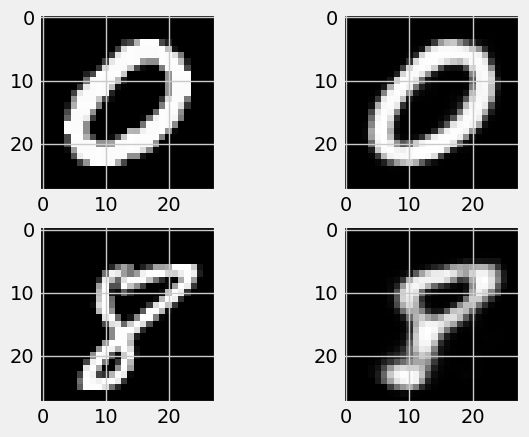

In [179]:
model.train()
images = []

for i in range(2):
    training_image_idx = np.random.randint(0, len(dataloader.dataset))   # get a random number from 0 to the length of the training set
    current_image = dataloader.dataset[training_image_idx][0]
    images.append(current_image)


images = torch.stack(images)
images = images.view(images.size(0), -1)
images = images.type(torch.float32)
images = Variable(images).to(device)
with torch.no_grad():
    bottleneck_tensors = model.encode(images).to(device)
    interpolated = torch.lerp(images[0], images[1], 0.5)
    #print(interpolated)
    output = model.decode(bottleneck_tensors).to(device)

#print(f"the output right after with: {output}")

bottleneck_tensors = bottleneck_tensors.cpu()
images = images.cpu()
output = output.cpu()
bottleneck_tensors = bottleneck_tensors.reshape(-1, 2, 16)
images = images.reshape(-1, 28, 28)
output = output.reshape(-1, 28, 28)

#print(f"the output right before matplotlib: {output}")

f = plt.figure()
f.add_subplot(2,2,1)
plt.imshow(images[0], cmap='gray')

f.add_subplot(2,2,2)
plt.imshow(output[0].detach().numpy(), cmap='gray')

f.add_subplot(2,2,3)
plt.imshow(images[1], cmap='gray')

f.add_subplot(2,2,4)
plt.imshow(output[1].detach().numpy(), cmap='gray')

plt.show(block=True)
